# DNN回归预测(CT)

In [107]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

In [108]:
Config = {
    'data_path': r'data\20220706.xlsx',
    'feature_num':12,
    'target' :'day_divided 3',
    'csv_path' : 'submission.csv',
    'k_fold': 5,
}

pd.set_option('display.max_columns', None) #原来中间会有部分列的显示被省略
pd.set_option('display.max_colwidth', None)
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)


# 读入数据

In [109]:
data = pd.read_excel((Config['data_path']))

# 删除无用列
data = data.drop(columns=['index', 'Admission time','Discharge time']) 

# 移动target至表尾
column_to_move = data.pop("day_hospitalized")

# insert column with insert(location, column_name, column_value)
data.insert(25, "day_hospitalized", column_to_move)

data.head()

,age,sex,Clinical classification on admission,Clinical classification at discharge,Clinical outcome at discharge,First physical examination Temperature,Fever at the first diagnosis,Height,Weight,Female menopause time,Past history score,ever had pneumonia before,ICU duration,Ventilator duration,Location of lesion is upper right,Location of lesion is right middle,Location of lesion is lower right,Location of lesion is upper left,Location of lesion is lower left,Total lesion volume,Proportion of total lung volume,Average density of all lesions,Total lesion volume at the last examination,proportion in the last examination,density of lesions at the last,day_hospitalized
0,25.0,1.0,1.0,2.0,1.0,38.2,1.0,176,72.0,NaN,2,0,0,0,0,0,1,1,1.0,172.04,3.68,-335.0,0.0,0.0,0.0,24
1,29.0,1.0,2.0,2.0,1.0,36.5,0.0,165,70.0,NaN,0,0,0,0,0,0,1,0,0.0,26.49,0.53,-621.0,0.0,0.0,0.0,17
2,30.0,1.0,2.0,2.0,1.0,36.0,0.0,175,67.5,NaN,0,0,0,0,0,0,0,0,0.0,0,0.00,0.0,0.0,0.0,0.0,13
3,41.0,2.0,0.0,0.0,1.0,36.5,1.0,156,72.5,NaN,0,0,0,0,0,0,0,0,0.0,0,0.00,0.0,0.0,0.0,0.0,22
4,29.0,2.0,1.0,2.0,1.0,39.0,1.0,160,70.0,NaN,0,0,0,0,0,0,1,1,1.0,44.36,1.20,-557.0,0.0,0.0,0.0,35


## 变量中英对照

序号 index
年龄(岁) age
性别(1=男，2=女）sex
入院时间（年/月/日）Admission time
出院时间（年/月/日）Discharge time
住院时长(天)  day_hospitalized
入院时临床分型（0=无症状感染者，1=轻型，2=普通型，3=重型，4=危重型） Clinical classification on admission
出院时临床分型（0=无症状感染者，1=轻型，2=普通型，3=重型，4=危重型）Clinical classification at discharge
出院时临床转归（0=临床治愈，1=病毒转阴）Clinical outcome at discharge
首次查体体温（℃）First physical examination Temperature
首诊时有无发热（0=否，1=是）Fever at the first diagnosis
身高（cm）Height
体重(kg) Weight
女性绝经时间 Female menopause time
既往史评分 Past history score
以前曾是否患过肺炎（0=否，1=是） ever had pneumonia before
ICU时长（天）ICU duration
呼吸机时长（小时）Ventilator duration
病灶位置是否右上（1=是，0=否）Location of lesion is upper right
病灶位置是否右中（1=是，0=否）Location of lesion is right middle
病灶位置是否右下（1=是，0=否）Location of lesion is lower right
病灶位置是否左上（1=是，0=否）Location of lesion is upper left
病灶位置是否左下（1=是，0=否）Lesion location is lower left
首次检查病灶体积总和 Total lesion volume
首次检查全部病灶占全肺体积占比 Proportion of total lung volume
首次检查全部病灶的平均密度 Average density of all lesions
末次检查病灶体积总和 Total lesion volume at the last examination
末次检查全部病灶占全肺体积占比 proportion in the last examination
末次检查全部病灶的平均密度 density of lesions at the last

## 处理空置

In [110]:
# print(data.isnull().sum())

#找到特定异常值 并修改

#找到异常值：1慢性支气管炎 位于 146，11 修改
data[data.eq("1慢性支气管炎").any(1)]
data.iloc[146,11] = 1

#找到异常值：1（1.28 18点-2.5 10点 ；2.16 18点-2.21 10点 位于 172，13 修改
data[data.eq("1（1.28 18点-2.5 10点 ；2.16 18点-2.21 10点").any(1)]
data.iloc[172,13] = 1

#找到异常值：4.4-4.28，具体小时数不详 位于 320，13 修改
data[data.eq("4.4-4.28，具体小时数不详").any(1)]
data.iloc[320,13] = 1


data[data.eq("17天").any(1)]
data.iloc[329,13] = 1


data[data.eq("病灶位置是否右下（1=是，0=否）").any(1)]
data.iloc[415,16] = 0


data[data.eq("8/1/00").any(1)]
data.iloc[334,-7] = 1


# data.iloc[334,-7]


In [111]:
# 适合用中位数填充的列
data['sex'].fillna(value=data['sex'].median(), inplace=True)
data['Clinical classification on admission'].fillna(value=data['Clinical classification on admission'].median(), inplace=True)
data['Clinical classification at discharge'].fillna(value=data['Clinical classification at discharge'].median(), inplace=True)
data['Clinical outcome at discharge'].fillna(value=data['Clinical outcome at discharge'].median(), inplace=True)
data['First physical examination Temperature'].fillna(value=data['First physical examination Temperature'].median(), inplace=True)
data['Fever at the first diagnosis'].fillna(value=data['Fever at the first diagnosis'].median(), inplace=True)
data['ever had pneumonia before'].fillna(value=data['ever had pneumonia before'].median(), inplace=True)
data['Location of lesion is lower left'].fillna(value=data['Location of lesion is lower left'].median(), inplace=True)

data['Total lesion volume at the last examination'].fillna(value=data['Total lesion volume at the last examination'].median(), inplace=True)
data[' proportion in the last examination'].fillna(value=data[' proportion in the last examination'].median(), inplace=True)
data['density of lesions at the last'].fillna(value=data['density of lesions at the last'].median(), inplace=True)
# data['Total lesion volume at the last examination'].fillna(value=data['Total lesion volume at the last examination'].median(), inplace=True)
# data['Total lesion volume at the last examination'].fillna(value=data['Total lesion volume at the last examination'].median(), inplace=True)

print(f'表格总数据量为：{data.shape[0]}')

表格总数据量为：441


In [112]:
# print(data.isnull().sum())

In [113]:
# 对缺失值超过半数的列 进行删除 Height->216  Weight->182 Female menopause time->353
data = data.drop(columns=['Height', 'Weight','Female menopause time']) 
data.head()


,age,sex,Clinical classification on admission,Clinical classification at discharge,Clinical outcome at discharge,First physical examination Temperature,Fever at the first diagnosis,Past history score,ever had pneumonia before,ICU duration,Ventilator duration,Location of lesion is upper right,Location of lesion is right middle,Location of lesion is lower right,Location of lesion is upper left,Location of lesion is lower left,Total lesion volume,Proportion of total lung volume,Average density of all lesions,Total lesion volume at the last examination,proportion in the last examination,density of lesions at the last,day_hospitalized
0,25.0,1.0,1.0,2.0,1.0,38.2,1.0,2,0,0,0,0,0,1,1,1.0,172.04,3.68,-335.0,0.0,0.0,0.0,24
1,29.0,1.0,2.0,2.0,1.0,36.5,0.0,0,0,0,0,0,0,1,0,0.0,26.49,0.53,-621.0,0.0,0.0,0.0,17
2,30.0,1.0,2.0,2.0,1.0,36.0,0.0,0,0,0,0,0,0,0,0,0.0,0,0.00,0.0,0.0,0.0,0.0,13
3,41.0,2.0,0.0,0.0,1.0,36.5,1.0,0,0,0,0,0,0,0,0,0.0,0,0.00,0.0,0.0,0.0,0.0,22
4,29.0,2.0,1.0,2.0,1.0,39.0,1.0,0,0,0,0,0,0,1,1,1.0,44.36,1.20,-557.0,0.0,0.0,0.0,35


In [114]:
# data.isnull().sum()
# data.info()
# 将连续值转为数值型列
data["Ventilator duration"] = pd.to_numeric(data["Ventilator duration"])
data["Total lesion volume"] = pd.to_numeric(data["Total lesion volume"])


# 将离散分类值转为整型
cat_list = ['sex','Clinical classification on admission','Clinical classification at discharge','Clinical outcome at discharge',
            'Past history score','ever had pneumonia before','Location of lesion is upper right','Location of lesion is right middle','Location of lesion is lower right',
            'Location of lesion is upper left','Location of lesion is lower left']
data[cat_list] = data[cat_list].astype(object)
# data.info()
train = data


In [115]:
# # 剔除小于10天和大于50天的数据
# train = train[train.day_hospitalized < 50]
# train = train[train.day_hospitalized > 10]

# train = train.reset_index()
# del train['index']

# 将数据集分为三天一单位
train[Config['target']] = 42
for x in range(train.shape[0]):
    train[Config['target']][x] = train['day_hospitalized'][x] / 3

# 数据集可视化
#Analysis the data distribution about label 'divided 3'
# train_visual = train
# train_result = train_visual.groupby('day_divided 3').size()
# plt.bar(list(train_result.index),train_result)
# plt.xlabel('Days')
# plt.ylabel('number')
# plt.title('trainData  \'3 divided\'  ')
# plt.show()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [116]:
from sklearn.model_selection import train_test_split

train_data,test_data = train_test_split(train,test_size=0.1,random_state=42)

train_data = train_data.reset_index()

test_data = test_data.reset_index()

print(train_data.shape,test_data.shape)

(396, 25) (45, 25)


In [117]:
print(train_data.shape)
print(test_data.shape)

(396, 25)
(45, 25)


In [118]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   index   age sex Clinical classification on admission  \
0     76  19.0   1                                    1   
1     33  24.0   1                                    1   
2    431  50.0   1                                    2   
3    305  27.0   1                                    2   

   density of lesions at the last  day_hospitalized  day_divided 3  
0                          -458.0                36             12  
1                             0.0                30             10  
2                          -702.0                33             11  
3                             0.0                28              9  


In [119]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression


features = train_data

# features.info()
# print(features.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])
x_data, y_data = train.iloc[:,:-2],train.iloc[:,-1]

#try choose your k best features
k = Config['feature_num']
selector = SelectKBest(score_func=f_regression, k=k)
result = selector.fit(x_data, y_data)

#result.scores_ inclues scores for each features
#np.argsort sort scores in ascending order by index, we reverse it to make it descending.
idx = np.argsort(result.scores_)[::-1]
# print(f'Top {k} Best feature score ')
# print(result.scores_[idx[:k]])

print(f'\nTop {k} Best feature index ')
print(idx[:k])

print(f'\nTop {k} Best feature name')
print(x_data.columns[idx[:k]])

selected_idx = list(np.sort(idx[:k]))
# print(list(x_data.columns[selected_idx]))

feature_list = list(x_data.columns[selected_idx])

selected_idx = [x+1 for x in selected_idx]



Top 12 Best feature index 
[ 3  2  0  9  5 15  4 12  6 10 13 14]

Top 12 Best feature name
Index(['Clinical classification at discharge',
       'Clinical classification on admission', 'age', 'ICU duration',
       'First physical examination Temperature',
       'Location of lesion is lower left', 'Clinical outcome at discharge',
       'Location of lesion is right middle', 'Fever at the first diagnosis',
       'Ventilator duration', 'Location of lesion is lower right',
       'Location of lesion is upper left'],
      dtype='object')


In [120]:
all_features = pd.concat((train_data.iloc[:, selected_idx], test_data.iloc[:, selected_idx]))

all_features = all_features.iloc[:,:]
all_features.head()


,age,Clinical classification on admission,Clinical classification at discharge,Clinical outcome at discharge,First physical examination Temperature,Fever at the first diagnosis,ICU duration,Ventilator duration,Location of lesion is right middle,Location of lesion is lower right,Location of lesion is upper left,Location of lesion is lower left
0,19.0,1,1,0,38.2,1.0,0,0.0,0,0,0,0
1,24.0,1,1,1,36.2,0.0,0,0.0,0,0,0,0
2,50.0,2,2,1,38.5,1.0,0,0.0,0,0,0,0
3,27.0,2,2,1,36.7,0.0,0,0.0,0,0,0,0
4,64.0,2,3,1,37.3,1.0,8,278.0,1,1,1,1


## 标准化

In [121]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

## 独热化

In [122]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(441, 33)

In [123]:
# 将数据转为torch
n_train = train_data.shape[0]

# 获取shap变量
origin_shap_test_features = all_features[n_train:]
shap_train_features = all_features[:n_train].to_numpy()
shap_test_features = all_features[n_train:].to_numpy()

# 变量转为tensor
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data[Config['target']].values.reshape(-1, 1), dtype=torch.float32)

# 网络搭建

## 网络结构及LOSS function

In [124]:
# 定义function
loss = nn.MSELoss()
in_features = train_features.shape[1]

# 定义网络结构
def get_net():
    net = nn.Sequential(nn.Linear(in_features,16),
                        nn.LeakyReLU(0.2),
                        nn.BatchNorm1d(16),
                        nn.Dropout(0.4),                        
                        nn.Linear(16, 8),
                        nn.LeakyReLU(0.2),
                        
                        nn.Linear(8, 4),
                        nn.LeakyReLU(0.2),
                        # nn.BatchNorm1d(16),
                        nn.Dropout(0.4),
                        nn.Linear(4, 1)
                        )
    return net

In [125]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    # rmse = torch.sqrt(loss(torch.log(clipped_preds),
    #                        torch.log(labels)))
    
    # MSE :
    rmse = loss(net(features),labels)
    return rmse.item()

In [126]:
## Adam 优化器

In [127]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

# $K$折交叉验证

In [128]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid
    # return X_train, y_train, X_train, y_train

当我们在$K$折交叉验证中训练$K$次后，[**返回训练和验证误差的平均值**]。


In [129]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='mse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练mse{float(train_ls[-1]):f}, '
              f'验证mse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

## 训练


折1，训练mse10.143002, 验证mse14.619489
折2，训练mse10.644519, 验证mse13.747568
折3，训练mse9.888052, 验证mse15.845579
折4，训练mse9.466665, 验证mse17.016632
折5，训练mse10.710535, 验证mse10.982739
5-折验证: 平均训练log mse: 10.170555, 平均验证log mse: 14.442402


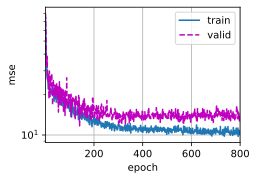

In [130]:
k, num_epochs, lr, weight_decay, batch_size = 5, 800, 2e-2, 0, 128
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log mse: {float(train_l):f}, '
      f'平均验证log mse: {float(valid_l):f}')

# 预测

In [131]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log mse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log mse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()

    # print(pd.Series(preds.reshape(1, -1)[0]))
    test_data['origin day_divided 3'] = test_data[Config['target']]
    test_data[Config['target']] = pd.Series(preds.reshape(1, -1)[0])
    # print(test_data[Config['target']])
    # reValidLoss = loss(test_data['origin day_divided 3'],test_data[Config['target']])
    # print(f'reValidLoss MSE :{reValidLoss}')
    submission = pd.concat([test_data['origin day_divided 3'], test_data[Config['target']]], axis=1)
    submission.to_csv(Config['csv_path'], index=False)
    return net

训练log mse：11.307172


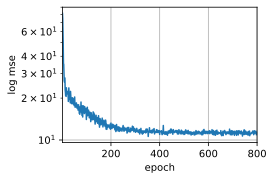

In [132]:
model = train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

The MSE Loss of test: 8.572257041931152


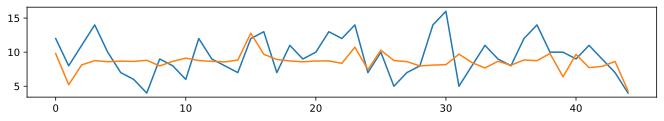

In [133]:

verifyData = pd.read_csv(Config['csv_path'])
# verifyData.iloc[:,0].tolist()
# a = verifyData.iloc[:,0].tolist()
origin = torch.FloatTensor(verifyData.iloc[:,0].tolist())
predict = torch.FloatTensor(verifyData.iloc[:,1].tolist())
print(f'The MSE Loss of test: {loss(origin,predict)}')

import matplotlib.pyplot as plt
plt.axes([0, 0, 2.5, 0.5])
plt.plot(origin)
plt.plot(predict)

plt.show()

In [134]:
import pandas as pd 
result1 = pd.read_csv(Config['csv_path'])
# result1['day_divided 3']

# SHAP 可解释性分析

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


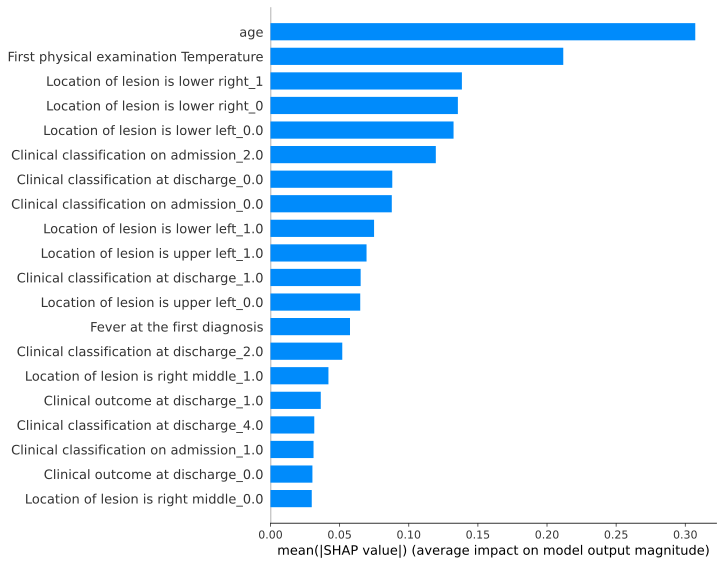

In [135]:
# import shap

# explainer = shap.DeepExplainer(model, shap_train_features)
# shap_values = explainer.shap_values(shap_test_features)
# shap.summary_plot(shap_values, shap_test_features, plot_type='bar')


import shap

explainer = shap.DeepExplainer(model, torch.from_numpy(shap_train_features).float())
shap_values = explainer.shap_values(torch.from_numpy(shap_test_features).float())
shap.summary_plot(shap_values, origin_shap_test_features, plot_type='bar')